HMM-DDM: Mouse Data
========================
In this notebook we will analyse a dataset of mice performing a two-alternative forced choice (TAFC) task developed in Kane, Senne, and Scott, 2025. mice performed this task daily in two-hour periods.

In [41]:
using HiddenMarkovModels
using DriftDiffusionModels
using Plots
using CSV
using DataFrames
using Dates
using Random
using Distributions
using LinearAlgebra
using StatsBase
using JLD2
using Printf

## Load and Preprocess the data

In [2]:
ddir = "../data/mouse_df.csv"
# load in the data
df = CSV.File(ddir) |> DataFrame;

In [52]:
# Group by animal name and count trials
trial_counts = combine(groupby(df, :name), nrow => :trial_count)

# Sort by count in descending order
sort!(trial_counts, :trial_count, rev=true)

# pick a mouse of interest (start with mouse of most trials)
moi = trial_counts[3, :name]

# get the data for the mouse of interest
mouse_df = df[df.name .== moi, :]

# Filter out trials with "omission" outcome
valid_trials = findall(outcome -> outcome != "omission", mouse_df.outcome)
filtered_df = mouse_df[valid_trials, :]

# Map correct -> 1 and incorrect -> -1 (only for error and correct, omissions are gone)
numeric_outcomes = [outcome == "correct" ? 1 : -1 for outcome in filtered_df.outcome]

# Get reaction times, filter out "NAN" values
valid_rt_indices = findall(rt -> uppercase(string(rt)) != "NAN", filtered_df.rt)

# Apply both filters to keep data aligned
final_df = filtered_df[valid_rt_indices, :]
final_outcomes = numeric_outcomes[valid_rt_indices]

# Convert RTs to Float64
# final_rts = [parse(Float64, rt) for rt in final_df.rt]
final_rts = final_df.rt

# Extract just the date part from the timestamp strings
dates = [Date(split(dt)[1]) for dt in final_df.trial_datetime]

# Get unique dates in chronological order
unique_dates = sort(unique(dates))

# Create a vector of vectors, where each inner vector contains DDMResults for one day
results_by_date = Vector{Vector{DDMResult}}()

for date in unique_dates
    # Get indices for this date
    day_indices = findall(dates .== date)
    
    # Skip days with no valid data
    if isempty(day_indices)
        continue
    end
    
    # Extract RTs and outcomes for this date
    day_rts = final_rts[day_indices]
    day_outcomes = final_outcomes[day_indices]
    
    # Create DDMResult objects for this day
    day_results = [DDMResult(rt, choice) for (rt, choice) in zip(day_rts, day_outcomes)]
    
    # Add to our vector of vectors
    push!(results_by_date, day_results)
end

# Now calculate the sequence ends (cumulative sum of lengths)
seq_ends = cumsum([length(seq) for seq in results_by_date])

# Concatenate all results into a single vector
all_results = reduce(vcat, results_by_date)

9748-element Vector{DDMResult}:
 DDMResult(0.3641, 1)
 DDMResult(2.6874, 1)
 DDMResult(0.2314, 1)
 DDMResult(0.7153, 1)
 DDMResult(0.285, 1)
 DDMResult(0.2506, 1)
 DDMResult(0.3101, -1)
 DDMResult(0.2258, -1)
 DDMResult(0.2381, 1)
 DDMResult(0.2624, 1)
 ⋮
 DDMResult(0.3761, -1)
 DDMResult(0.3078, -1)
 DDMResult(0.5333, -1)
 DDMResult(0.4485, 1)
 DDMResult(0.3003, -1)
 DDMResult(0.5327, 1)
 DDMResult(0.468, -1)
 DDMResult(0.3793, 1)
 DDMResult(0.4822, 1)

# Visualize the correct and error RT distirbutions

In [23]:
correct_trials = [x for x in all_results if x.choice == 1]
incorrect_trials = [x for x in all_results if x.choice == -1];

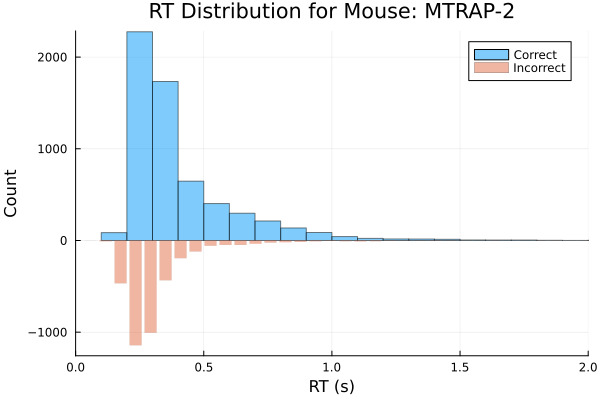

In [24]:
rt_dist_plot = histogram([x.rt for x in correct_trials], bins=100, alpha=0.5, label="Correct", legend=:topright)
incorrect_rts = [x.rt for x in incorrect_trials]
h = fit(Histogram, incorrect_rts, range(0, maximum(incorrect_rts), length=101))
bar!(h.edges[1][1:end-1], -h.weights, width=step(h.edges[1]), 
     alpha=0.5, 
     label="Incorrect")
# Adjust y-axis to make room for the downward bars
xlabel!("RT (s)")
ylabel!("Count")
title!("RT Distribution for Mouse: $moi")
ylims!(minimum([-h.weights; 0]) * 1.1, maximum(h.weights) * 2)
xlims!(0, 2)

## Two State Model

In [ ]:
# generate a HMM to start from
trans_guess = [0.95 0.05; 0.05 0.95]
init_guess = [0.99, 0.01]

ddm_1_guess = DriftDiffusionModel(5.0, 0.1, 0.5, 0.75, 1)
ddm_2_guess = DriftDiffusionModel(0.5, 1.0, 0.5, 0.05, 1)

dists_guess = [ddm_1_guess, ddm_2_guess]

# create a prior distirbution for the initial states and transition matrix (sticky HMM)
α₀ = ones(2)
αₜ = ones(2, 2) .* 2
# αₜ[diagind(αₜ)] .= 2

hmm = PriorHMM(init_guess, trans_guess, dists_guess, αₜ, α₀)

hmm_est, lls = baum_welch(hmm, all_results; seq_ends=seq_ends)

## Save Results: Optional

In [12]:
@save joinpath("..\\data\\results", moi* "_hmm.jld2") hmm_est

## Confirm the LL converges!

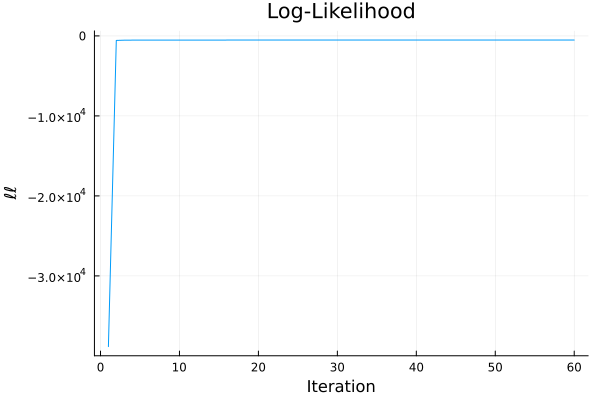

In [26]:
plot(lls, title="Log-Likelihood", xlabel="Iteration", ylabel="ℓℓ", legend=false)

## Plot the Posterior Distribution of the States


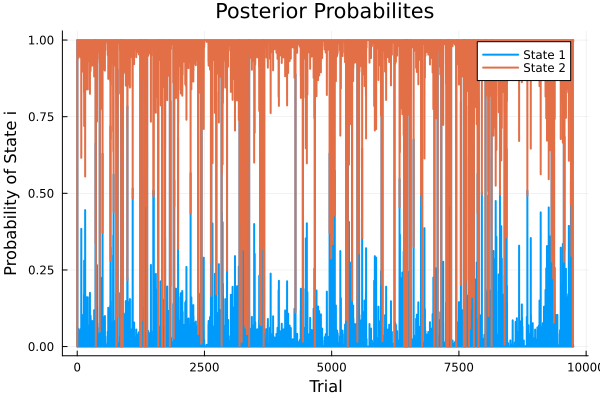

In [27]:
# get the posterior distribution of the hidden states
posterior = forward(hmm_est, all_results; seq_ends=seq_ends)
γ = posterior[1]

plot(γ[1, :], title="Posterior Probabilites", xlabel="Trial", ylabel="Probability of State i", label="State 1", linewidth=2)
plot!(γ[2, :], label="State 2", linewidth=2)

## Post-Hoc Analysis of HMM-DDM

In [4]:
fitted_models = [load(joinpath("../data/results", mouse_name * "_hmm.jld2")) for mouse_name in trial_counts.name[1:3]]

3-element Vector{Dict{String, Any}}:
 Dict("hmm_est" => PriorHMM{Float64, DriftDiffusionModel}([1.3803721855404444e-55, 1.0], [0.14414223209800106 0.855857767901999; 0.017240848229831938 0.9827591517701681], DriftDiffusionModel[DriftDiffusionModel(2.889062556363124, 0.4453114408619728, 0.5, 0.38532568865648087, 1.0), DriftDiffusionModel(0.9852460258976712, 0.6989372832996007, 0.5, 0.15842913655199614, 1.0)], [2.0 2.0; 2.0 2.0], [1.0, 1.0]))
 Dict("hmm_est" => PriorHMM{Float64, DriftDiffusionModel}([0.09498017816522879, 0.9050198218347711], [0.07422128987072638 0.9257787101292737; 0.018666336700157018 0.981333663299843], DriftDiffusionModel[DriftDiffusionModel(3.4512996167135355, 0.46861080370825237, 0.5, 0.797004640644837, 1.0), DriftDiffusionModel(1.036102496804745, 0.7838860574307834, 0.5, 0.17589720131023087, 1.0)], [2.0 2.0; 2.0 2.0], [1.0, 1.0]))
 Dict("hmm_est" => PriorHMM{Float64, DriftDiffusionModel}([0.1310986618426928, 0.8689013381573073], [0.13664722670122095 0.8633527732987

In [56]:
fitted_models[1]["hmm_est"]

PriorHMM{Float64, DriftDiffusionModel}([1.3803721855404444e-55, 1.0], [0.14414223209800106 0.855857767901999; 0.017240848229831938 0.9827591517701681], DriftDiffusionModel[DriftDiffusionModel(2.889062556363124, 0.4453114408619728, 0.5, 0.38532568865648087, 1.0), DriftDiffusionModel(0.9852460258976712, 0.6989372832996007, 0.5, 0.15842913655199614, 1.0)], [2.0 2.0; 2.0 2.0], [1.0, 1.0])

In [6]:
results_by_date

21-element Vector{Vector{DDMResult}}:
 [DDMResult(0.2716, 1), DDMResult(0.4124, -1), DDMResult(0.2669, 1), DDMResult(0.8428, 1), DDMResult(0.3541, 1), DDMResult(0.247, 1), DDMResult(0.4099, 1), DDMResult(0.2372, -1), DDMResult(0.3275, -1), DDMResult(0.2344, 1)  …  DDMResult(0.4317, 1), DDMResult(0.5033, 1), DDMResult(0.4301, -1), DDMResult(0.3224, 1), DDMResult(0.3798, -1), DDMResult(0.3051, 1), DDMResult(3.7027, 1), DDMResult(0.3506, -1), DDMResult(5.3012, 1), DDMResult(4.6419, 1)]
 [DDMResult(0.8441, 1), DDMResult(0.3666, 1), DDMResult(0.2861, -1), DDMResult(0.3645, -1), DDMResult(0.4149, 1), DDMResult(1.1449, 1), DDMResult(0.6274, 1), DDMResult(0.2682, 1), DDMResult(0.2219, -1), DDMResult(0.3468, 1)  …  DDMResult(0.3339, 1), DDMResult(0.2727, -1), DDMResult(0.2656, -1), DDMResult(0.5035, 1), DDMResult(0.2498, 1), DDMResult(0.292, 1), DDMResult(0.5313, -1), DDMResult(0.4316, 1), DDMResult(0.3043, -1), DDMResult(0.5975, 1)]
 [DDMResult(0.3584, 1), DDMResult(0.4253, -1), DDMResult(0.26

In [11]:
function plot_two_state_hmm_heatmap(state1_probs::Vector{Float64}, sequence_ends::Vector{Int}; 
                                  color_scheme=:viridis, 
                                  fig_size=(900, 400),
                                  title="Probability of State 1")
    # state1_probs is a vector of length N (total time points across all sequences)
    # containing probabilities of being in State 1
    
    N = length(state1_probs)
    
    # Calculate sequence starts
    sequence_starts = [1; sequence_ends[1:end-1] .+ 1]
    n_sequences = length(sequence_ends)
    
    # Find maximum sequence length
    max_length = maximum(sequence_ends .- sequence_starts .+ 1)
    
    # Create data array for the heatmap (initialize with NaN)
    heatmap_data = fill(NaN, (n_sequences, max_length))
    
    # Fill in data for each sequence
    for seq in 1:n_sequences
        start_idx = sequence_starts[seq]
        end_idx = sequence_ends[seq]
        seq_length = end_idx - start_idx + 1
        
        # Extract probabilities for this sequence
        heatmap_data[seq, 1:seq_length] = state1_probs[start_idx:end_idx]
    end
    
    # Create the heatmap
    hm = heatmap(heatmap_data,
                c=color_scheme,
                title=title,
                xlabel="Time Step",
                ylabel="Sequence",
                yticks=(1:n_sequences, ["Seq $i" for i in 1:n_sequences]),
                clim=(0,1),
                colorbar_title="Probability",
                fillalpha=0.8,
                size=fig_size)
    
    return hm
end

plot_two_state_hmm_heatmap (generic function with 1 method)

In [53]:
# posterior 
posterior = forward(fitted_models[2]["hmm_est"], all_results; seq_ends=seq_ends)
γ = posterior[1]

# Plot the heatmap for the first fitted model
heatmap_plot = plot_two_state_hmm_heatmap(γ[1, :], seq_ends; color_scheme=:viridis, fig_size=(900, 600))
savefig(heatmap_plot, "/Users/ryansenne/Desktop/NeurIPS_2025_Plots/heatmap_plot.png")

"\\Users\\ryansenne\\Desktop\\NeurIPS_2025_Plots\\heatmap_plot.png"

In [44]:
function state_dependent_histogram(true_data::Tuple{Vector{DDMResult}, Vector{Int}},
                                 simulated_data::Tuple{Vector{DDMResult}, Vector{Int}},
                                 n_bins::Int=100)
    # Unpack the data
    true_results, true_states = true_data
    sim_results, sim_states = simulated_data
    
    # Create empty plots
    p1 = plot(title="State 1 Response Times", xlabel="RT (s)", ylabel="Density")
    p2 = plot(title="State 2 Response Times", xlabel="RT (s)", ylabel="Density")
    
    # Stratify data by state and correctness
    # State 1
    state1_true_idx = findall(x -> x == 1, true_states)
    state1_sim_idx = findall(x -> x == 1, sim_states)
    
    state1_true_correct = [r.rt for (i, r) in enumerate(true_results) if i in state1_true_idx && r.choice == 1]
    state1_true_error = [r.rt for (i, r) in enumerate(true_results) if i in state1_true_idx && r.choice == -1]
    
    state1_sim_correct = [r.rt for (i, r) in enumerate(sim_results) if i in state1_sim_idx && r.choice == 1]
    state1_sim_error = [r.rt for (i, r) in enumerate(sim_results) if i in state1_sim_idx && r.choice == -1]
    
    # State 2
    state2_true_idx = findall(x -> x == 2, true_states)
    state2_sim_idx = findall(x -> x == 2, sim_states)
    
    state2_true_correct = [r.rt for (i, r) in enumerate(true_results) if i in state2_true_idx && r.choice == 1]
    state2_true_error = [r.rt for (i, r) in enumerate(true_results) if i in state2_true_idx && r.choice == -1]
    
    state2_sim_correct = [r.rt for (i, r) in enumerate(sim_results) if i in state2_sim_idx && r.choice == 1]
    state2_sim_error = [r.rt for (i, r) in enumerate(sim_results) if i in state2_sim_idx && r.choice == -1]
    
    # Handle case where arrays might be empty
    if isempty(state1_true_correct) && isempty(state1_true_error) && 
       isempty(state1_sim_correct) && isempty(state1_sim_error) &&
       isempty(state2_true_correct) && isempty(state2_true_error) && 
       isempty(state2_sim_correct) && isempty(state2_sim_error)
        return plot(title="No data available")
    end
    
    # Find common RT range for appropriate binning
    all_rts = vcat(
        state1_true_correct, state1_true_error, state1_sim_correct, state1_sim_error,
        state2_true_correct, state2_true_error, state2_sim_correct, state2_sim_error
    )
    
    min_rt = minimum(all_rts)
    max_rt = maximum(all_rts)
    rt_range = (min_rt, max_rt)
    
    # Calculate histogram data manually
    # Create the bins
    bin_edges = range(min_rt, max_rt, length=n_bins+1)
    bin_width = (max_rt - min_rt) / n_bins
    bin_centers = range(min_rt + bin_width/2, max_rt - bin_width/2, length=n_bins)
    
    # Function to compute histogram heights
    function compute_hist_heights(data, normalize=true)
        if isempty(data)
            return zeros(n_bins)
        end
        hist = fit(Histogram, data, bin_edges)
        heights = hist.weights
        if normalize
            heights = heights ./ (sum(heights) * bin_width)
        end
        return heights
    end
    
    # Compute histogram heights for all datasets
    s1_true_correct_heights = compute_hist_heights(state1_true_correct)
    s1_true_error_heights = compute_hist_heights(state1_true_error)
    s1_sim_correct_heights = compute_hist_heights(state1_sim_correct)
    s1_sim_error_heights = compute_hist_heights(state1_sim_error)
    
    s2_true_correct_heights = compute_hist_heights(state2_true_correct)
    s2_true_error_heights = compute_hist_heights(state2_true_error)
    s2_sim_correct_heights = compute_hist_heights(state2_sim_correct)
    s2_sim_error_heights = compute_hist_heights(state2_sim_error)
    
    # Plot histograms using bar plots
    # State 1 - Correct trials (positive y-axis)
    bar!(p1, bin_centers, s1_true_correct_heights, 
        label="True Data (Correct)", alpha=0.8, color=:blue, 
        bar_width=bin_width, linewidth=0)
    
    bar!(p1, bin_centers, s1_sim_correct_heights, 
        label="Simulated Data (Correct)", alpha=0.8, color=:lightblue, 
        bar_width=bin_width, linewidth=0)
    
    # State 1 - Error trials (negative y-axis)
    bar!(p1, bin_centers, -s1_true_error_heights, 
        label="True Data (Error)", alpha=0.8, color=:red, 
        bar_width=bin_width, linewidth=0)
    
    bar!(p1, bin_centers, -s1_sim_error_heights, 
        label="Simulated Data (Error)", alpha=0.8, color=:pink, 
        bar_width=bin_width, linewidth=0)
    
    # State 2 - Correct trials (positive y-axis)
    bar!(p2, bin_centers, s2_true_correct_heights, 
        label="True Data (Correct)", alpha=0.8, color=:blue, 
        bar_width=bin_width, linewidth=0)
    
    bar!(p2, bin_centers, s2_sim_correct_heights, 
        label="Simulated Data (Correct)", alpha=0.8, color=:lightblue, 
        bar_width=bin_width, linewidth=0)
    
    # State 2 - Error trials (negative y-axis)
    bar!(p2, bin_centers, -s2_true_error_heights, 
        label="True Data (Error)", alpha=0.8, color=:red, 
        bar_width=bin_width, linewidth=0)
    
    bar!(p2, bin_centers, -s2_sim_error_heights, 
        label="Simulated Data (Error)", alpha=0.8, color=:pink, 
        bar_width=bin_width, linewidth=0)
    
    # Add horizontal line at y=0
    hline!(p1, [0], color=:black, linestyle=:dash, label=nothing)
    hline!(p2, [0], color=:black, linestyle=:dash, label=nothing)
    
    # Manually set y-ticks with absolute values as labels
    # Find the maximum y value (positive or negative) to set symmetric ticks
    max_y1 = max(
        maximum(s1_true_correct_heights), 
        maximum(s1_sim_correct_heights),
        maximum(s1_true_error_heights),
        maximum(s1_sim_error_heights)
    )
    
    max_y2 = max(
        maximum(s2_true_correct_heights), 
        maximum(s2_sim_correct_heights),
        maximum(s2_true_error_heights),
        maximum(s2_sim_error_heights)
    )
    
    # Create symmetric tick positions
    y_ticks1 = collect(range(-max_y1, max_y1, length=7))
    y_ticks2 = collect(range(-max_y2, max_y2, length=7))

    # Format tick labels with restricted significant figures (2 decimal places)
    format_tick(y) = @sprintf("%.2f", abs(y))

    # Set ticks with formatted absolute values as labels
    yticks!(p1, y_ticks1, [format_tick(y) for y in y_ticks1])
    yticks!(p2, y_ticks2, [format_tick(y) for y in y_ticks2])
    
    # Add annotations 
    max_correct_height1 = maximum(s1_true_correct_heights)
    max_error_height1 = maximum(s1_true_error_heights)
    
    max_correct_height2 = maximum(s2_true_correct_heights)
    max_error_height2 = maximum(s2_true_error_heights)
    
    # Create combined plot
    combined_plot = plot(p1, p2, layout=(2,1), size=(1100, 800), legend=:topright)
    
    return combined_plot
end

state_dependent_histogram (generic function with 2 methods)

In [54]:
true_data_tuple = (all_results, [val > 0.5 ? 1 : 2 for val in γ[1, :]])

# generate some data from the fitted model
seqs_sim, data_sim = rand(fitted_models[2]["hmm_est"], length(all_results))
simulated_data_tuple = (data_sim, seqs_sim)



(DDMResult[DDMResult(0.7048879999994321, -1), DDMResult(0.5794969999958264, 1), DDMResult(0.7564610000009151, 1), DDMResult(0.6161199999968795, 1), DDMResult(0.34833299999759837, 1), DDMResult(0.5361229999945791, 1), DDMResult(0.23030900000020965, 1), DDMResult(0.45022999999487207, 1), DDMResult(0.2731129999996109, -1), DDMResult(0.3735069999969248, 1)  …  DDMResult(0.7562250000009083, 1), DDMResult(6.828668000600593, 1), DDMResult(0.5834239999959393, 1), DDMResult(0.28125999999939294, -1), DDMResult(0.2918089999991107, 1), DDMResult(0.2669689999997753, 1), DDMResult(0.23882400000021817, 1), DDMResult(0.6938719999991153, 1), DDMResult(0.3943009999963685, 1), DDMResult(0.6026969999964935, 1)], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  2, 1, 2, 2, 2, 2, 2, 2, 2, 2])

In [55]:
# Plot the state-dependent histograms
histogram_plot = state_dependent_histogram(true_data_tuple, simulated_data_tuple)
savefig(histogram_plot, "/Users/ryansenne/Desktop/NeurIPS_2025_Plots/state_dependent_histogram.png")

"\\Users\\ryansenne\\Desktop\\NeurIPS_2025_Plots\\state_dependent_histogram.png"